In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # for plot styling
import numpy as np

## simple example of K means clustering: 4 distinct blobs

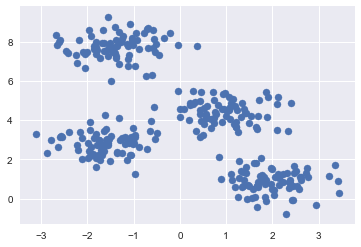

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                      cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kemeans = kmeans.predict(X)

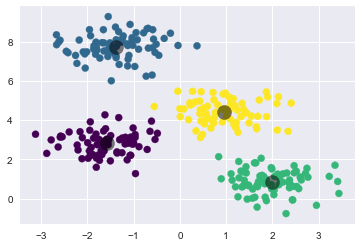

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y_kemeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

## Creating a simple clustering algorithm

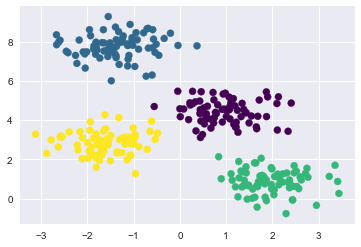

In [5]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    #1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centeres from means of points
        new_centers = np.array([X[labels == i].mean(0)
                              for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels


centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
           s=50, cmap='viridis');

### demonstration of a shitty clustering using E-M method.

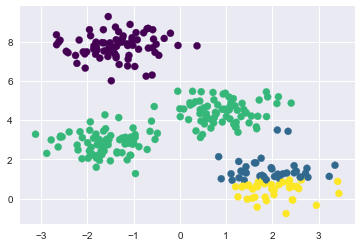

In [6]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
           s=50, cmap='viridis');

## For this 4 center cluster data, lets tell model there are 6 clusters

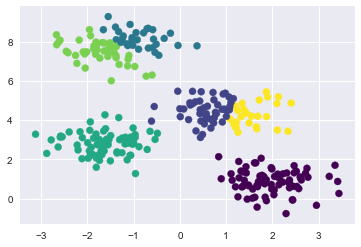

In [7]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
           s=50, cmap='viridis');

## complicated geometries

In [8]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

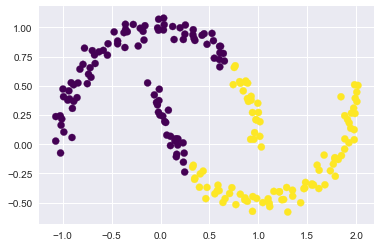

In [9]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
           s=50, cmap='viridis');

## build in kernel transformation - spectral clustering

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


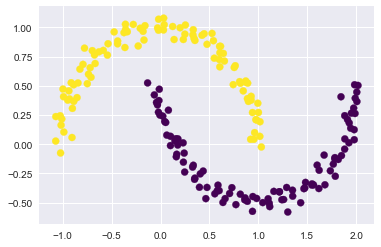

In [10]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2,
                          affinity='nearest_neighbors',
                          assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
           s=50, cmap='viridis');

## example use k means on digits

In [11]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [13]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

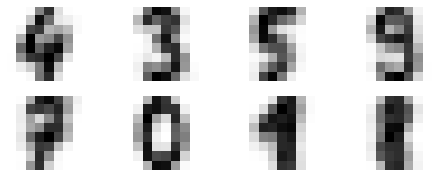

In [15]:
fig, ax = plt.subplots(2, 4, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [19]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [20]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7935447968836951

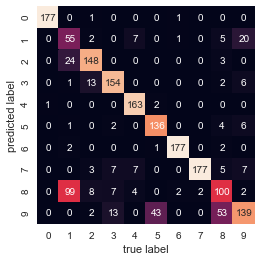

In [21]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [23]:
from sklearn.manifold import TSNE

#project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='pca', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

#compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]
    
#compute the accuracy
accuracy_score(digits.target, labels)

0.9371174179187535

### k means for colour compression

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\datasets\base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\datasets\base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]


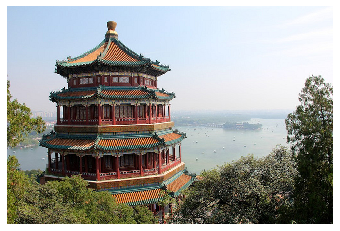

In [29]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

In [30]:
china.shape

(427, 640, 3)

In [31]:
data = china / 255.0
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

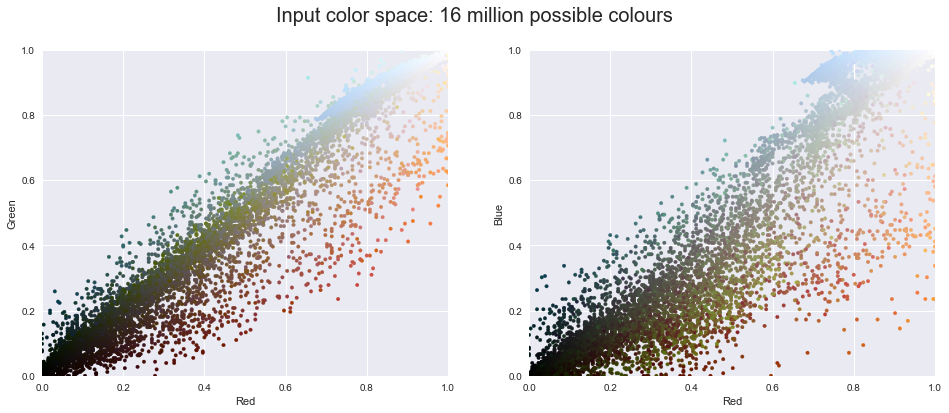

In [34]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    #choose a random soubset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))
    
    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))
    
    fig.suptitle(title, size=20);
    
plot_pixels(data, title='Input color space: 16 million possible colours')

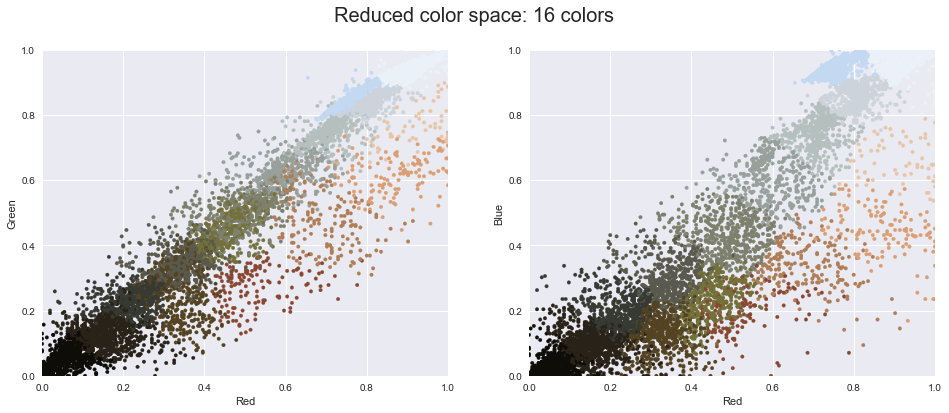

In [36]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
           title="Reduced color space: 16 colors")

Text(0.5,1,'16-color Image')

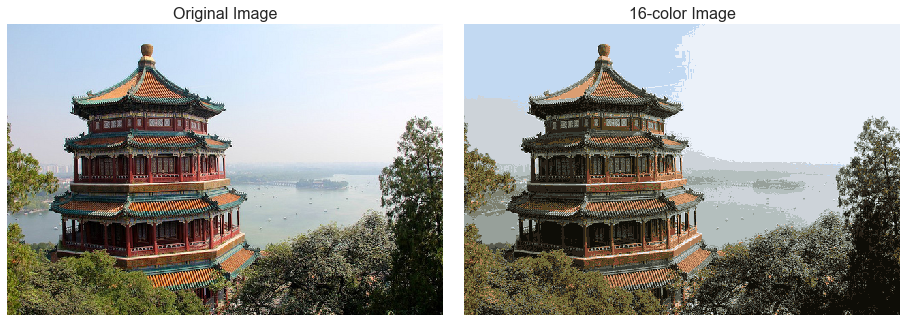

In [37]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                      subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16)

# Gaussian Mixture Models

### back to k means clusters - ok for blobs

In [5]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                      cluster_std=0.60, random_state=0)
# flip axis for better plotting
X= X[:, ::-1]

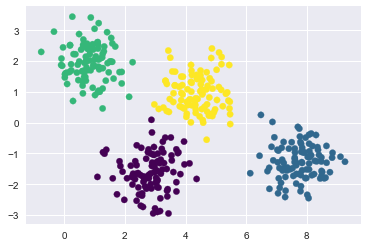

In [6]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0)
labels = kmeans.fit(X).predict(X)


plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')



## visualising K means as circles

In [9]:
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    
    #plot input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:,0], X[:,1], c=labels, s=40, cmap='viridis', zorder=2)
    
    #plot the representation of the k-means model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
            for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

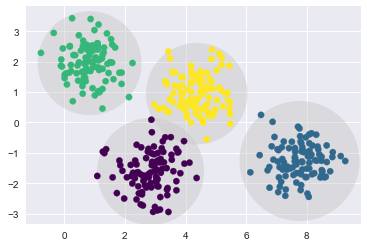

In [10]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

stretching the data to show impact in kmeans

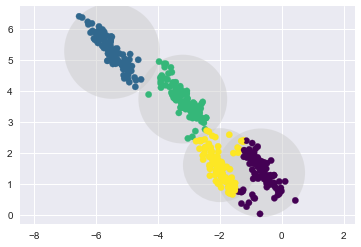

In [12]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

### Gaussian mixture models at simplest emulate KMeans

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Fun

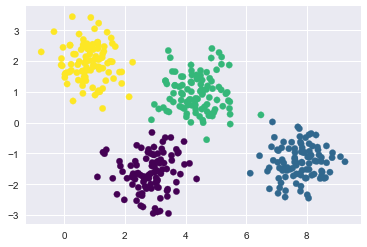

In [13]:
from sklearn.mixture import GMM
gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

In [14]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.475 0.525 0.   ]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    1.    0.   ]
 [1.    0.    0.    0.   ]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


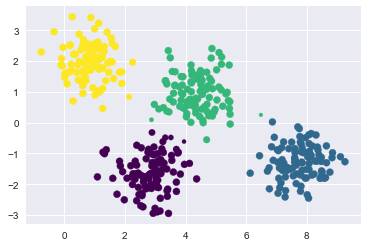

In [15]:
#size of blob related to probability of being in the cluster
size = 50 * probs.max(1) ** 2
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

visualizing the shape of the GMM clusters

In [16]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellopse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1,0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
        
    #Draw the ellpise
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                            angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder = 2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Fun

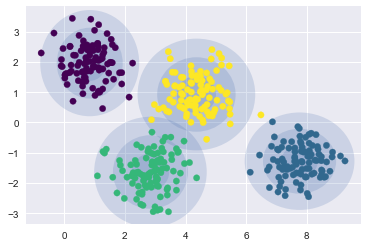

In [18]:
gmm = GMM(n_components=4, random_state=42)
plot_gmm(gmm, X)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Fun

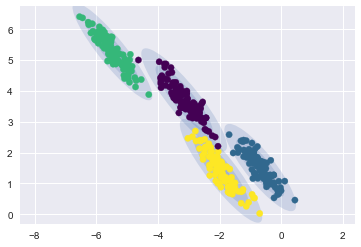

In [20]:
gmm = GMM(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)